In [1]:
%env LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/
%env TF_GPU_ALLOCATOR=cuda_malloc_async

env: LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/
env: TF_GPU_ALLOCATOR=cuda_malloc_async


In [1]:
import os
print(os.environ["LD_LIBRARY_PATH"])

:/home/nkspartan/miniconda3/envs/tf-gpu/lib/


In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import keras
import matplotlib.pyplot as plt

from tensorflow.keras import Sequential, models, Input
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, LeakyReLU, AveragePooling2D, GlobalAveragePooling2D, BatchNormalization, TimeDistributed, LSTM, SpatialDropout2D
from tensorflow.keras.optimizers import SGD, Adam

2022-10-20 10:50:14.909786: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-20 10:50:15.417277: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-20 10:50:16.397115: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/nkspartan/miniconda3/envs/tf-gpu/lib/:/home/nkspartan/miniconda3/envs/tf-gpu/lib/
2022-10-20 10:50:16.397188: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 

In [2]:
from tensorflow.python.client import device_lib

#print(device_lib.list_local_devices())
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

Default GPU Device: /device:GPU:0


2022-10-20 10:50:17.959211: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-20 10:50:17.978165: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-20 10:50:18.029770: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-20 10:50:18.029956: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

## Read the csv dataset to get the values for stage and discharge of the images

In [3]:
df = pd.read_csv("../../dataset/2012_2019_PlatteRiverWeir_features_merged_all.csv")
df.head()

,Unnamed: 0,SensorTime,CaptureTime,Filename,Agency,SiteNumber,TimeZone,Stage,Discharge,CalcTimestamp,...,WeirPt2X,WeirPt2Y,WwRawLineMin,WwRawLineMax,WwRawLineMean,WwRawLineSigma,WwCurveLineMin,WwCurveLineMax,WwCurveLineMean,WwCurveLineSigma
0,0,2012-06-09 13:15:00,2012-06-09T13:09:07,StateLineWeir_20120609_Farrell_001.jpg,USGS,6674500,MDT,2.99,916.0,2020-03-11T16:58:28,...,-1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2012-06-09 13:15:00,2012-06-09T13:10:29,StateLineWeir_20120609_Farrell_002.jpg,USGS,6674500,MDT,2.99,916.0,2020-03-11T16:58:33,...,-1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2012-06-09 13:45:00,2012-06-09T13:44:01,StateLineWeir_20120609_Farrell_003.jpg,USGS,6674500,MDT,2.96,873.0,2020-03-11T16:58:40,...,-1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,2012-06-09 14:45:00,2012-06-09T14:44:30,StateLineWeir_20120609_Farrell_004.jpg,USGS,6674500,MDT,2.94,846.0,2020-03-11T16:58:47,...,-1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,2012-06-09 15:45:00,2012-06-09T15:44:59,StateLineWeir_20120609_Farrell_005.jpg,USGS,6674500,MDT,2.94,846.0,2020-03-11T16:58:55,...,-1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
df = df[["Filename", "Stage", "Discharge", 'SensorTime']]

In [5]:
df['SensorTime'] = pd.to_datetime(df['SensorTime'])
df['Year'] = df['SensorTime'].dt.year
df.head()

,Filename,Stage,Discharge,SensorTime,Year
0,StateLineWeir_20120609_Farrell_001.jpg,2.99,916.0,2012-06-09 13:15:00,2012
1,StateLineWeir_20120609_Farrell_002.jpg,2.99,916.0,2012-06-09 13:15:00,2012
2,StateLineWeir_20120609_Farrell_003.jpg,2.96,873.0,2012-06-09 13:45:00,2012
3,StateLineWeir_20120609_Farrell_004.jpg,2.94,846.0,2012-06-09 14:45:00,2012
4,StateLineWeir_20120609_Farrell_005.jpg,2.94,846.0,2012-06-09 15:45:00,2012


### Scale the data

In [6]:
from sklearn.preprocessing import StandardScaler
from joblib import load

#scaler = StandardScaler()
scaler = load('std_scaler.joblib')

In [7]:
df[["Stage", "Discharge"]] = scaler.fit_transform(df[["Stage", "Discharge"]])
df


,Filename,Stage,Discharge,SensorTime,Year
0,StateLineWeir_20120609_Farrell_001.jpg,0.138117,-0.046094,2012-06-09 13:15:00,2012
1,StateLineWeir_20120609_Farrell_002.jpg,0.138117,-0.046094,2012-06-09 13:15:00,2012
2,StateLineWeir_20120609_Farrell_003.jpg,0.100875,-0.082160,2012-06-09 13:45:00,2012
3,StateLineWeir_20120609_Farrell_004.jpg,0.076046,-0.104807,2012-06-09 14:45:00,2012
4,StateLineWeir_20120609_Farrell_005.jpg,0.076046,-0.104807,2012-06-09 15:45:00,2012
...,...,...,...,...,...
42054,StateLineWeir_20191011_Farrell_409.jpg,-0.420526,-0.450369,2019-10-11 09:00:00,2019
42055,StateLineWeir_20191011_Farrell_410.jpg,-0.420526,-0.450369,2019-10-11 10:00:00,2019
42056,StateLineWeir_20191011_Farrell_411.jpg,-0.420526,-0.450369,2019-10-11 11:00:00,2019
42057,StateLineWeir_20191011_Farrell_412.jpg,-0.420526,-0.450369,2019-10-11 12:00:00,2019


In [8]:
from joblib import dump
#dump(scaler, 'std_scaler.joblib')

## Create the dataset pipeline

In [9]:
#IMG_SIZE = 224
IMG_SIZE = 512
BATCH_SIZE = 32

In [10]:
from glob import glob

def make_dataset(path, batch_size, df, seed=None, years=False):
  np.random.seed(seed)

  def parse_image(filename):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.rgb_to_grayscale(image)
    image = tf.image.grayscale_to_rgb(image)
    #image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])

    image = tf.cast(image, tf.float32) / 255

    return image

  def configure_for_performance(ds):
    if not years:
      ds = ds.shuffle(buffer_size=100)
    ds = ds.batch(batch_size)
    ds = ds.repeat()
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

  train_files = []
  val_files = []
  test_files = []
  
  if years:
    files = df[(df.Year >= 2012) & (df.Year <= 2016)].Filename.values
    train_files = [os.path.join(path, file) for file in files]
    print(len(train_files))

    files = df[(df.Year >= 2017) & (df.Year <= 2017)].Filename.values
    val_files = [os.path.join(path, file) for file in files]
    print(len(val_files))

    files = df[(df.Year >= 2018) & (df.Year <= 2019)].Filename.values
    test_files = [os.path.join(path, file) for file in files]
    print(len(test_files))
  else:
    filenames = glob(path + '/*')
    # make train, val and test splits of the dataset (70%, 10%, 20% split)
    split1 = int(0.7 * len(filenames))
    split2 = int(0.8 * len(filenames))

    np.random.shuffle(filenames)
    train_files = filenames[:split1] # up to split 1 (ex 70%)
    val_files = filenames[split1:split2] # from ex. 70% to 80%
    test_files = filenames[split2:] # from ex. 80% until the end

  # create stage values
  stage_train_values = [df[df.Filename == file.split('/')[-1]].Stage.values for file in train_files]
  stage_val_values = [df[df.Filename == file.split('/')[-1]].Stage.values for file in val_files]
  stage_test_values = [df[df.Filename == file.split('/')[-1]].Stage.values for file in test_files]

  # create discharge values
  discharge_train_values = [df[df.Filename == file.split(
      '/')[-1]].Discharge.values for file in train_files]
  discharge_val_values = [df[df.Filename == file.split(
      '/')[-1]].Discharge.values for file in val_files]
  discharge_test_values = [df[df.Filename == file.split(
      '/')[-1]].Discharge.values for file in test_files]

  # join stage and discharge values
  stage_discharge_train_values = [[np.squeeze(s), np.squeeze(d)] for s, d in zip(stage_train_values, discharge_train_values)]
  stage_discharge_val_values = [[np.squeeze(s), np.squeeze(d)] for s, d in zip(stage_val_values, discharge_val_values)]
  stage_discharge_test_values = [[np.squeeze(s), np.squeeze(
      d)] for s, d in zip(stage_test_values, discharge_test_values)]

  # create images dataset (train, val, test)
  filenames_train_ds = tf.data.Dataset.from_tensor_slices(train_files)
  filenames_val_ds = tf.data.Dataset.from_tensor_slices(val_files)
  filenames_test_ds = tf.data.Dataset.from_tensor_slices(test_files)

  images_train_ds = filenames_train_ds.map(parse_image, num_parallel_calls=8)
  images_val_ds = filenames_val_ds.map(parse_image, num_parallel_calls=8)
  images_test_ds = filenames_test_ds.map(parse_image, num_parallel_calls=8)

  # create stage and discharge dataset (train, val, test)
  stage_discharge_train_ds = tf.data.Dataset.from_tensor_slices(stage_discharge_train_values)
  stage_discharge_val_ds = tf.data.Dataset.from_tensor_slices(stage_discharge_val_values)
  stage_discharge_test_ds = tf.data.Dataset.from_tensor_slices(
      stage_discharge_test_values)

  # create tensorflow dataset of images and values (train, val, test)
  train_ds = tf.data.Dataset.zip((images_train_ds, stage_discharge_train_ds))
  train_ds = configure_for_performance(train_ds)
  val_ds = tf.data.Dataset.zip((images_val_ds, stage_discharge_val_ds))
  val_ds = configure_for_performance(val_ds)
  test_ds = tf.data.Dataset.zip((images_test_ds, stage_discharge_test_ds))
  test_ds = configure_for_performance(test_ds)

  return train_ds, len(train_files), val_ds, len(val_files), test_ds, len(test_files)

In [11]:
path = "../../dataset/images"

train_ds, train_size, val_ds, val_size, test_ds, test_size = make_dataset(path, BATCH_SIZE, df, 10, True)

21421
7390
13248


2022-10-20 10:53:17.487744: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-20 10:53:17.487945: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-20 10:53:17.488101: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-20 10:53:17.488638: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-20 10:53:17.488791: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

In [12]:
input_shape = 0
output_shape = 0

for image, stage_discharge in train_ds.take(1):
    print(image.numpy().shape)
    print(stage_discharge.numpy().shape)

    input_shape = image.numpy().shape[1:]
    output_shape = stage_discharge.numpy().shape[1:]

(32, 512, 512, 3)
(32, 2)


In [13]:
print(input_shape)
print(output_shape)

(512, 512, 3)
(2,)


## Check images

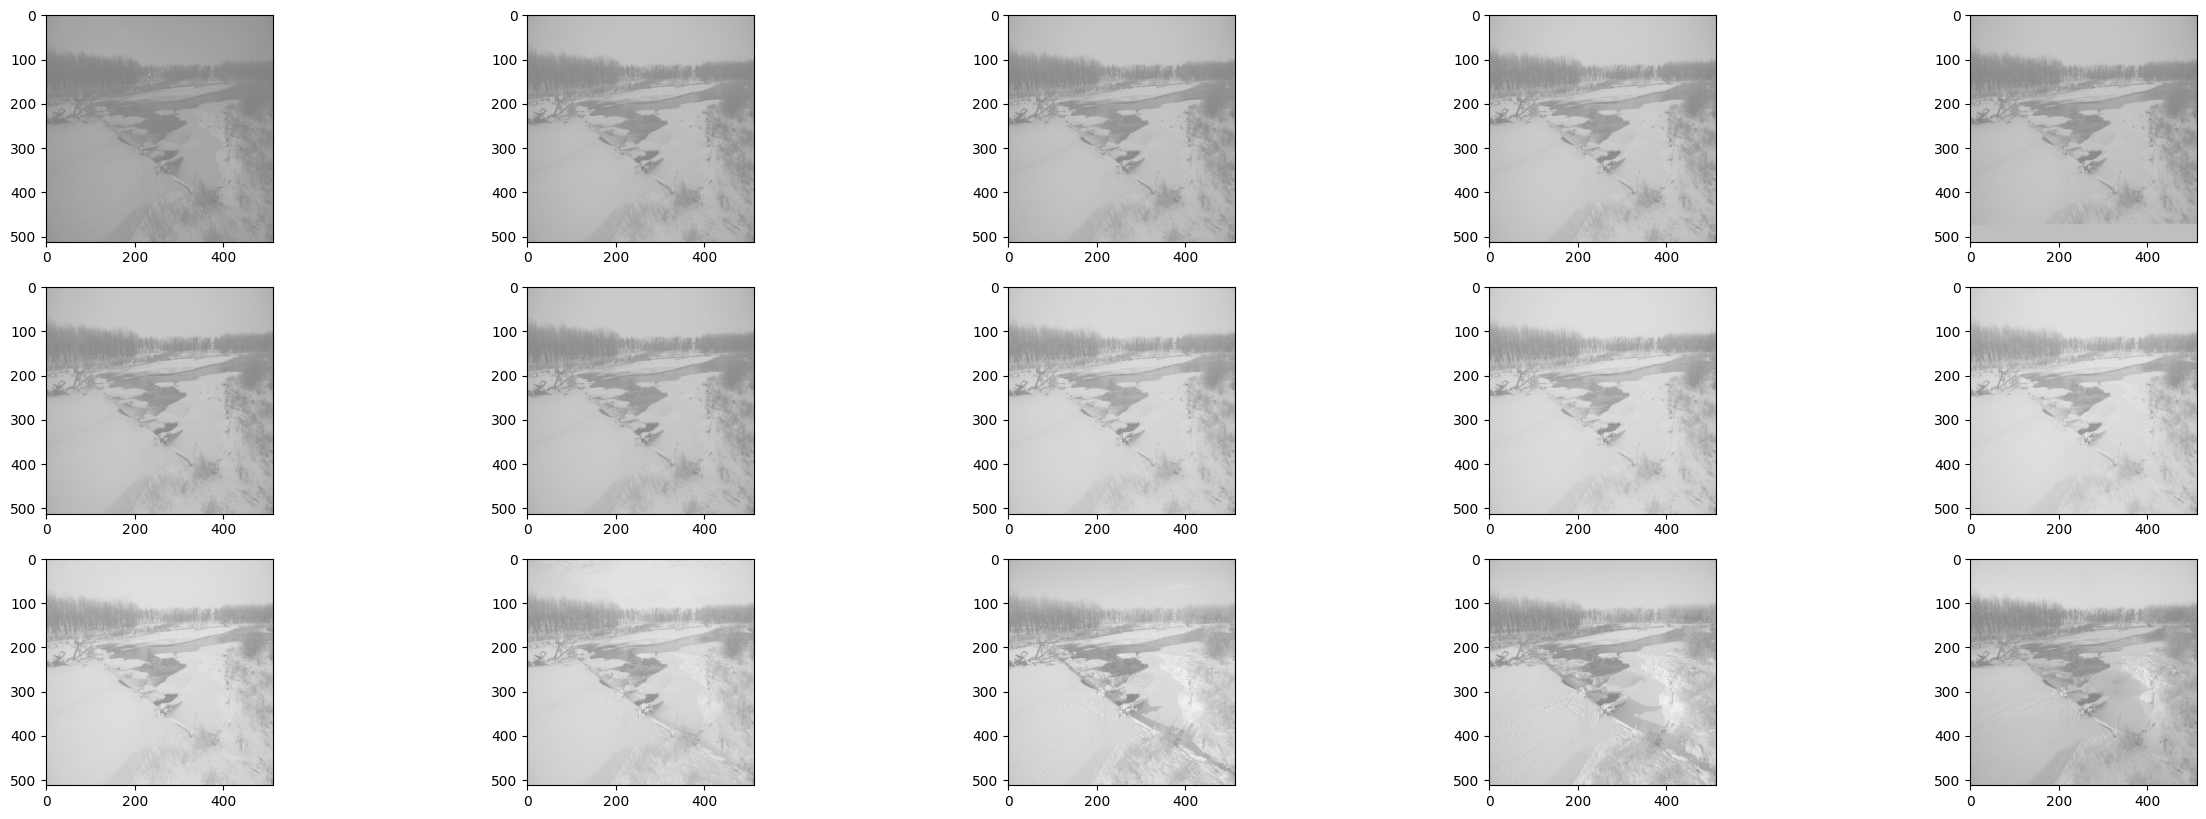

In [14]:
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(30, 10))

for image, stage_discharge in test_ds.take(1):
    images = image[:15]
    for img, ax in zip(images, ax.flatten()):
        img = img.numpy()
        img = img / 2 + 0.5     # unnormalize
        ax.imshow(img)

plt.show()

## Create model

In [15]:
def create_model(input_shape, output_shape, transfer_learning=False):
    model = Sequential()

    if (transfer_learning == True):
        base_model = tf.keras.applications.ResNet50V2(include_top=False,
                                                weights='imagenet',
                                                input_shape=input_shape)
        base_model.trainable = False
        base_model._name = 'base_model_ResNet50V2'

        model.add(base_model)
        model.add(Dropout(0.6))
        model.add(GlobalAveragePooling2D())

        model.add(Dense(128, activation='elu'))
        model.add(Dense(128, activation='elu'))
        model.add(Dense(128, activation='elu'))
        model.add(Dense(128, activation='elu'))
        model.add(Dense(64, activation='elu'))
        model.add(Dense(64, activation='elu'))
        model.add(Dense(32, activation='elu'))
        model.add(Dense(32, activation='elu'))
    else:
        model.add(Input(shape=input_shape))

        model.add(TimeDistributed(Conv2D(64, kernel_size=(4, 4), strides=(2, 2), padding='same', activation=LeakyReLU())))
        model.add(TimeDistributed(SpatialDropout2D(0.5)))
        model.add(TimeDistributed(MaxPooling2D(pool_size=(4, 4))))

        model.add(TimeDistributed(Conv2D(64, kernel_size=(4, 4), strides=(2, 2), activation=LeakyReLU(), padding='same')))
        model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

        model.add(TimeDistributed(Conv2D(32, kernel_size=(3, 3), activation=LeakyReLU(0.2), padding='same')))
        #model.add(AveragePooling2D(pool_size=(2, 2)))
        
        model.add(TimeDistributed(Conv2D(32, kernel_size=(3, 3), activation='relu')))

        model.add(TimeDistributed(Conv2D(32, kernel_size=(2, 2), activation='relu')))
        model.add(TimeDistributed(AveragePooling2D(pool_size=(2, 2))))

        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(4))

        model.add(Dense(128, activation='tanh'))
        model.add(Dense(64, activation='tanh'))
        model.add(Dense(32, activation='tanh'))
        model.add(Dense(32, activation='tanh'))
        
    model.add(Dense(output_shape, activation='linear')) # linear regression output layer

    return model


In [16]:
model = create_model(input_shape, output_shape[0], True)

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 base_model_ResNet50V2 (Func  (None, 16, 16, 2048)     23564800  
 tional)                                                         
                                                                 
 dropout (Dropout)           (None, 16, 16, 2048)      0         
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 128)               1

In [18]:
def compile_model(loss_func, optimizer, metrics=["accuracy"]):
    model.compile(loss=loss_func, optimizer=optimizer, metrics=metrics)

In [19]:
sgd = SGD(learning_rate=0.01, decay=1e-4, momentum=0.9, nesterov=True)
adam = Adam(learning_rate=1e-3, decay=1e-3 / 300)

compile_model('mse', adam,  [
              'mse', tf.keras.metrics.RootMeanSquaredError(name='rmse'), 'mae', 'mape'])


In [20]:
def fit_model(training_values, validation_values=None, epochs=10, steps=32, val_steps=32, callbacks=[]):
    return model.fit(training_values, validation_data=validation_values, epochs=epochs, steps_per_epoch=steps, validation_steps=val_steps, callbacks=callbacks)

In [21]:
import datetime

date_actual = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs/fit/" + date_actual
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f"model_weights/{date_actual}_cnn_best_weights.hdf5",
                               monitor='val_mse',
                               verbose=1,
                               save_best_only=True)


In [22]:
# batch_size = 0 because we already have batch size in tf dataset
model_h = fit_model(train_ds, val_ds, epochs=20, steps=np.ceil(train_size / BATCH_SIZE), val_steps=np.ceil(val_size / BATCH_SIZE), callbacks=[tensorboard_callback, checkpoint_callback])

Epoch 1/20


2022-10-20 10:53:26.064787: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-10-20 10:53:27.275456: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-10-20 10:53:27.276399: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-10-20 10:53:27.276419: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-10-20 10:53:27.277323: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-10-20 10:53:27.277383: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-10-20 10:53:28.318981: W tensorflow/core/common_runtime/bf

670/670 [==============================] - ETA: 0s - loss: 0.1581 - mse: 0.1581 - rmse: 0.3976 - mae: 0.2412 - mape: 119.4076
Epoch 1: val_mse improved from inf to 1.45439, saving model to model_weights/20221020-105322_cnn_best_weights.hdf5
670/670 [==============================] - 377s 552ms/step - loss: 0.1581 - mse: 0.1581 - rmse: 0.3976 - mae: 0.2412 - mape: 119.4076 - val_loss: 1.4544 - val_mse: 1.4544 - val_rmse: 1.2060 - val_mae: 0.9135 - val_mape: 170.9051
Epoch 2/20
670/670 [==============================] - ETA: 0s - loss: 0.2642 - mse: 0.2642 - rmse: 0.5140 - mae: 0.3198 - mape: 128.0963
Epoch 2: val_mse improved from 1.45439 to 1.28308, saving model to model_weights/20221020-105322_cnn_best_weights.hdf5
670/670 [==============================] - 382s 571ms/step - loss: 0.2642 - mse: 0.2642 - rmse: 0.5140 - mae: 0.3198 - mape: 128.0963 - val_loss: 1.2831 - val_mse: 1.2831 - val_rmse: 1.1327 - val_mae: 0.8348 - val_mape: 149.1957
Epoch 3/20
670/670 [=========================

KeyboardInterrupt: 

## Evaluate model

In [ ]:
print(date_actual)

20221019-123926


In [ ]:
best_model = models.load_model(f'model_weights/{date_actual}_cnn_best_weights.hdf5')
#best_model = models.load_model(f'best_models_weights/cnn_best_weights_v9.hdf5')


In [ ]:
def evaluate_model(model, test_values, steps):
  score = model.evaluate(test_values, steps=steps)
  return score

In [ ]:
test_loss, test_mse, test_rmse, test_mae, test_mape = evaluate_model(best_model, test_ds, steps=np.ceil(test_size / BATCH_SIZE))

414/414 [==============================] - 27s 63ms/step - loss: 0.0612 - mse: 0.0612 - rmse: 0.2474 - mae: 0.1708 - mape: 108.7451


In [ ]:
#predictions = best_model.predict(test_ds, steps=np.ceil(test_size / BATCH_SIZE))

In [ ]:
for image, stage_discharge in test_ds.take(1):
	predictions = best_model.predict(x=image)

	stage_discharge_test_values = stage_discharge[:2].numpy()
	predictions_values = predictions[:2]
	
	diff = predictions_values.flatten() - stage_discharge_test_values.flatten()
	percentDiff = (diff / stage_discharge_test_values.flatten()) * 100
	absPercentDiff = np.abs(percentDiff)
	# compute the mean and standard deviation of the absolute percentage
	# difference
	mean = np.mean(absPercentDiff)
	std = np.std(absPercentDiff)
	# finally, show some statistics on our model
	print(mean)
	print(std)

	stage_discharge_test_values = stage_discharge[:10]
	predictions_values = predictions[:10]

	for i in range(len(stage_discharge_test_values.numpy())):
		print(f"pred stage: {scaler.inverse_transform(predictions_values)[i][0]}, actual stage: {scaler.inverse_transform(stage_discharge_test_values)[i][0]}")
		print(f"pred discharge: {scaler.inverse_transform(predictions_values)[i][1]}, actual discharge: {scaler.inverse_transform(stage_discharge_test_values)[i][1]}")

1/1 [==============================] - 0s 394ms/step
15.7830886393434
10.003663744853409
pred stage: 2.298187732696533, actual stage: 2.35
pred discharge: 213.0644073486328, actual discharge: 264.0
pred stage: 2.2669639587402344, actual stage: 1.97
pred discharge: 199.0528106689453, actual discharge: 79.10000000000002
pred stage: 3.040494441986084, actual stage: 3.29
pred discharge: 989.4105224609375, actual discharge: 1290.0
pred stage: 2.4197428226470947, actual stage: 2.4
pred discharge: 247.0016632080078, actual discharge: 301.0
pred stage: 2.4485435485839844, actual stage: 2.4
pred discharge: 262.3414001464844, actual discharge: 301.0
pred stage: 2.297772169113159, actual stage: 1.98
pred discharge: 212.0349884033203, actual discharge: 80.60000000000002
pred stage: 3.01236629486084, actual stage: 3.03
pred discharge: 947.9930419921875, actual discharge: 971.0
pred stage: 3.4547359943389893, actual stage: 3.07
pred discharge: 1631.0565185546875, actual discharge: 992.0
pred stage: 

### Residual analysis

In [ ]:
y_predictions = np.empty(shape=(1, 2))
y_real = np.empty(shape=(1, 2))

"""for image, stage_discharge in test_ds.take(100):
    y_predictions = np.concatenate((y_predictions, best_model.predict(x=image)))
    y_real = np.concatenate((y_real, stage_discharge.numpy()))"""

'for image, stage_discharge in test_ds.take(100):\n    y_predictions = np.concatenate((y_predictions, best_model.predict(x=image)))\n    y_real = np.concatenate((y_real, stage_discharge.numpy()))'

/tmp/ipykernel_16114/3264406076.py:11: RuntimeWarning: divide by zero encountered in divide
  plt.scatter(y_real_discharge, residual_discharge / residual_discharge.std(), label="discharge residuals")


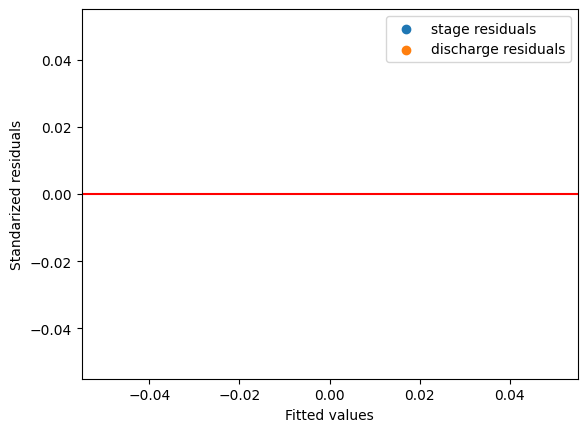

In [ ]:
residuals = y_real - y_predictions
residuals_std = residuals/residuals.std()

y_real_stage = np.array([i[0] for i in y_real])
residual_stage = np.array([i[0] for i in residuals])

y_real_discharge = np.array([i[1] for i in y_real])
residual_discharge = np.array([i[1] for i in residuals])

plt.scatter(y_real_stage, residual_stage / residual_stage.std(), label="stage residuals")
plt.scatter(y_real_discharge, residual_discharge / residual_discharge.std(), label="discharge residuals")
plt.axhline(y=0.0, color='r', linestyle='-')
plt.xlabel("Fitted values")
plt.ylabel("Standarized residuals")

plt.legend()
plt.show()

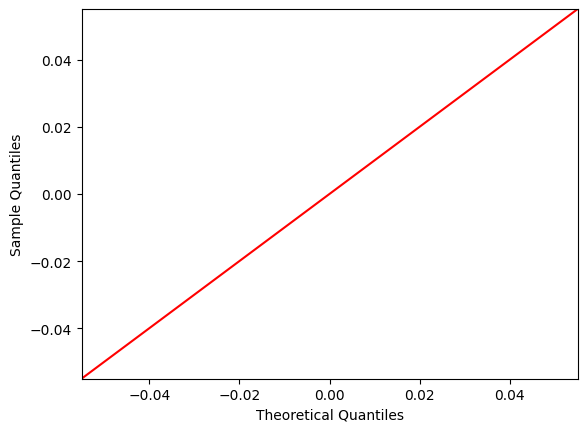

In [ ]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import normal_ad

figure = sm.qqplot(residual_stage / residual_stage.std(), line ='45', label='stage')
plt.show()

/tmp/ipykernel_16114/1192211388.py:1: RuntimeWarning: divide by zero encountered in divide
  figure = sm.qqplot(residual_discharge / residual_discharge.std(), line='45', label='discharge')


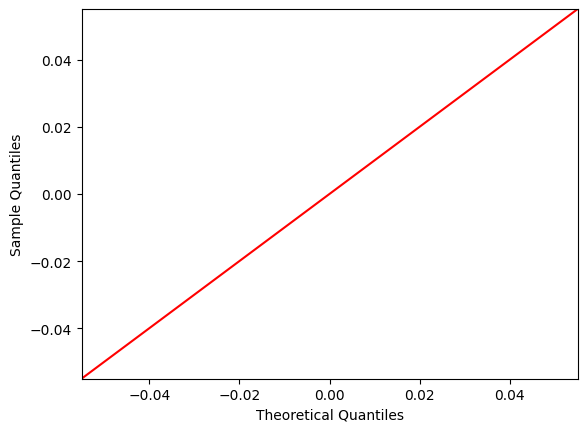

In [ ]:
figure = sm.qqplot(residual_discharge / residual_discharge.std(), line='45', label='discharge')
plt.show()

In [ ]:
import seaborn as sns

#sns.histplot(residuals, kde=True, bins = 10)

In [ ]:
stat, pval = normal_ad(residual_stage)
print("p-value:", pval)

if pval<0.05:
    print("Hay evidencia de que los residuos no provienen de una distribución normal.")
else:
    print("No hay evidencia para rechazar la hipótesis de que los residuos vienen de una distribución normal.")

p-value: 0.0
Hay evidencia de que los residuos no provienen de una distribución normal.


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [ ]:
stat, pval = normal_ad(residual_discharge)
print("p-value:", pval)

if pval < 0.05:
    print("Hay evidencia de que los residuos no provienen de una distribución normal.")
else:
    print("No hay evidencia para rechazar la hipótesis de que los residuos vienen de una distribución normal.")


p-value: 0.0
Hay evidencia de que los residuos no provienen de una distribución normal.


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## Visualize layers

In [ ]:
layer_outputs = [layer.output for layer in best_model.layers[:12]] 
# Extracts the outputs of the top 12 layers
activation_model = models.Model(inputs=best_model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

In [ ]:
activations = activation_model.predict(test_ds.take(1)) 

1/1 [==============================] - 0s 244ms/step


2022-10-19 13:19:32.359861: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 536870912 exceeds 10% of free system memory.


conv2d_5
max_pooling2d_5
conv2d_6
max_pooling2d_6
conv2d_7
conv2d_8
conv2d_9
average_pooling2d_1
flatten_1


/tmp/ipykernel_16114/1031377702.py:24: RuntimeWarning: invalid value encountered in divide
  channel_image /= channel_image.std()


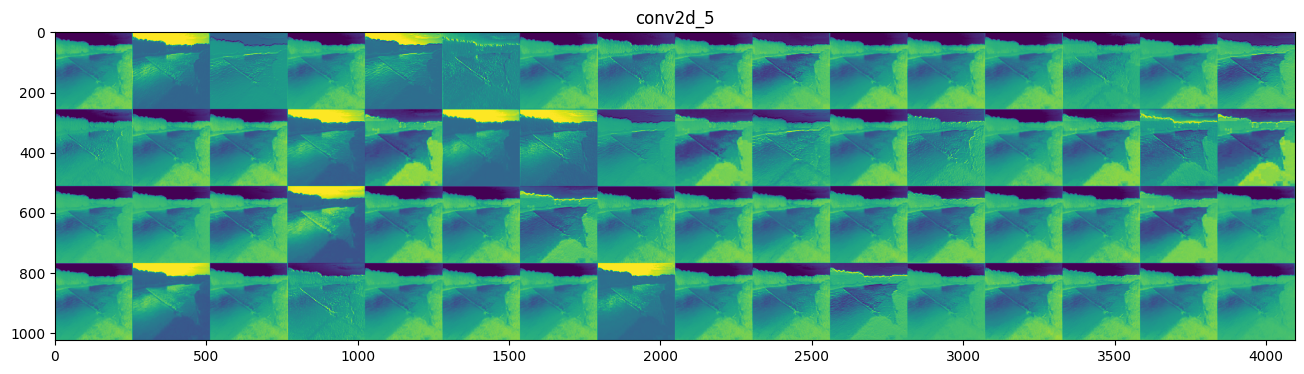

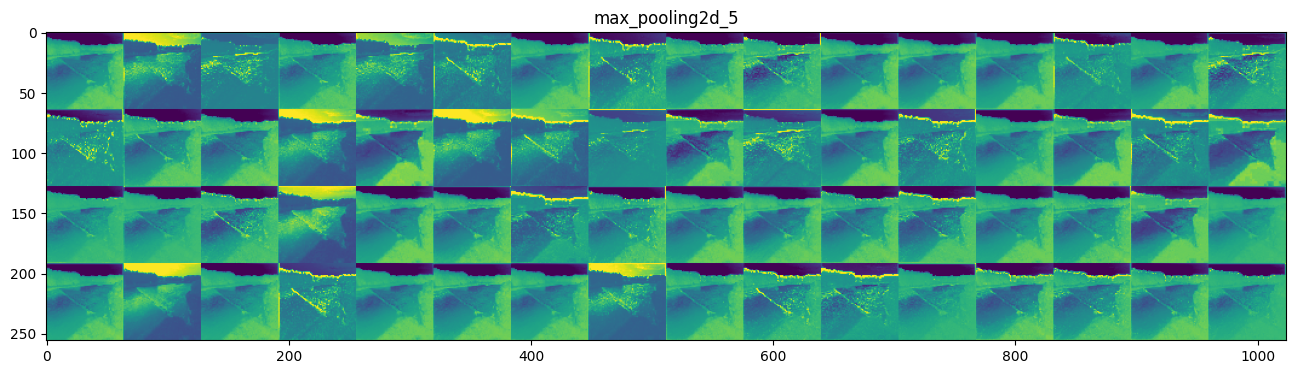

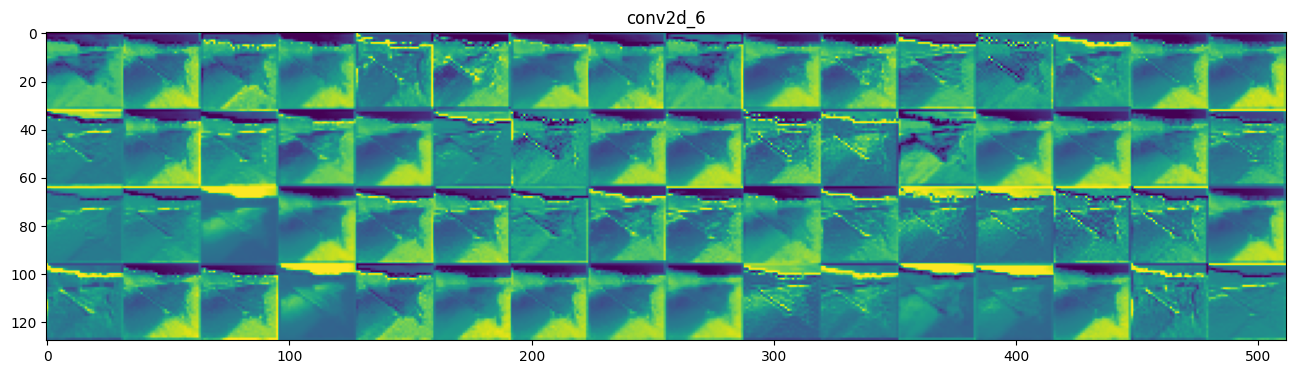

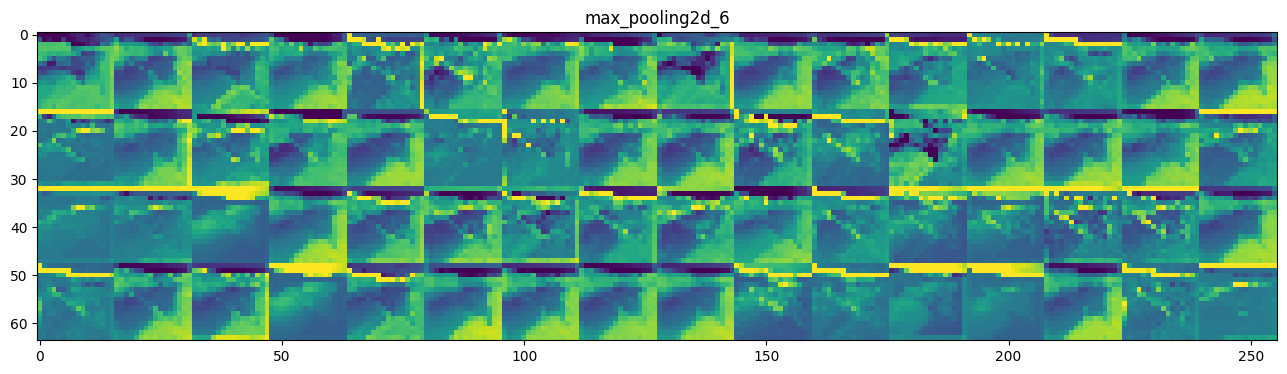

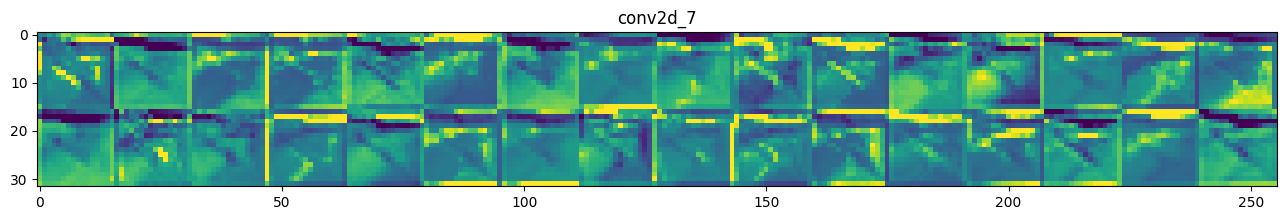

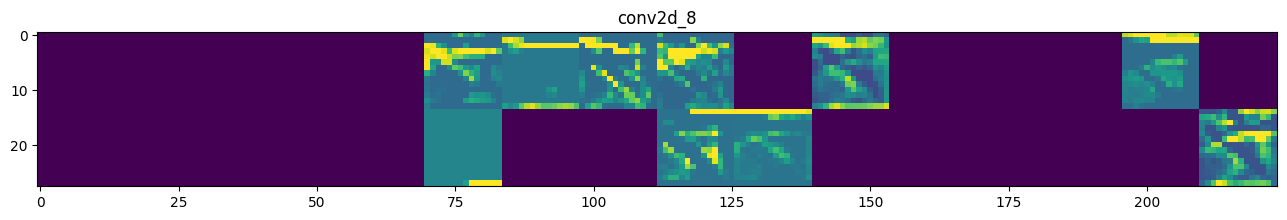

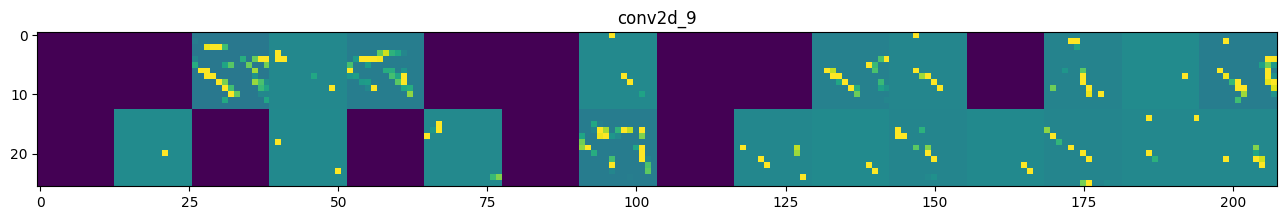

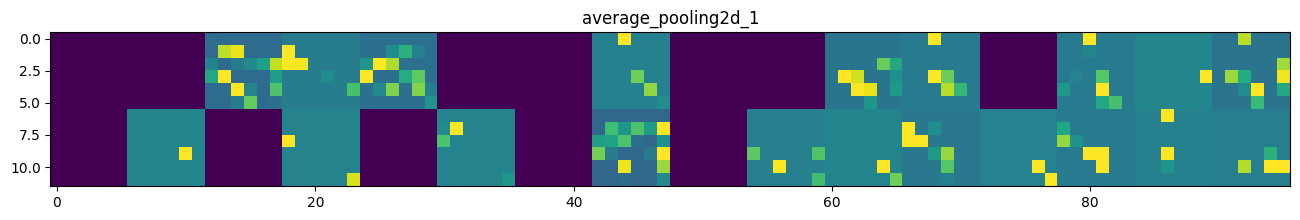

In [ ]:
import matplotlib.pyplot as plt

layer_names = []
for layer in best_model.layers[:12]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    
    print(layer_name)
    if "flatten" in layer_name or "dense" in layer_name: break

    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')